In [1]:
from pathlib import Path
import sys, os

ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(ROOT))

print("ROOT =", ROOT)

ROOT = /home/gridsan/manderson/skyscraper-s2


In [2]:
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from utils.backbones import load_backbone, prepare_image_for_backbone, extract_backbone_features

/home/gridsan/manderson/.conda/envs/skyscraper/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_feats(jpg_path, model, backbone_type, device):
    with torch.no_grad():
        img = Image.open(jpg_path).convert("RGB")

        # (1, C, H, W) float32 on device
        x = (
            torch.from_numpy(np.array(img))
            .permute(2, 0, 1)
            .unsqueeze(0)
            .float()
            .to(device)
        )
        # Resize to 224x224
        x = F.interpolate(x, size=(224, 224), mode="bicubic", align_corners=False)
        #print(x.shape)

        x = prepare_image_for_backbone(x, backbone_type)

        feats = extract_backbone_features(x, model, backbone_type)

        #print(jpg_path.name, feats.shape)

    return feats

In [4]:
def plot_feats(feats):
    # Average over last dimension
    grid = feats.mean(dim=-1).squeeze(0)   # -> [16, 16]

    # Move to CPU if needed
    grid = grid.detach().cpu()

    plt.figure()
    plt.imshow(grid)
    plt.colorbar()
    plt.title("Patch Mean Features")
    plt.show()

In [5]:
def eval_cpd(jpg_paths, model, backbone_type, device):
    for jpg_path in jpg_paths:
        feats = get_feats(jpg_path, model, backbone_type=backbone_type, device=device)
        # Reshape back to 16x16
        B, N, D = feats.shape       
        H = W = int(N ** 0.5)
        feats = feats.reshape(B, H, W, D)
        print(feats.shape)
        plot_feats(feats)

In [6]:
root_dir = '/home/gridsan/manderson/skyscraper-s2/data/skyscraper_gdelt_sentinel'
backbone_type = 'remoteclip-14'

loaded remoteclip-14!
debug
4463 articles found!

=== 1065924641 (5 images) ===
torch.Size([1, 16, 16, 1024])


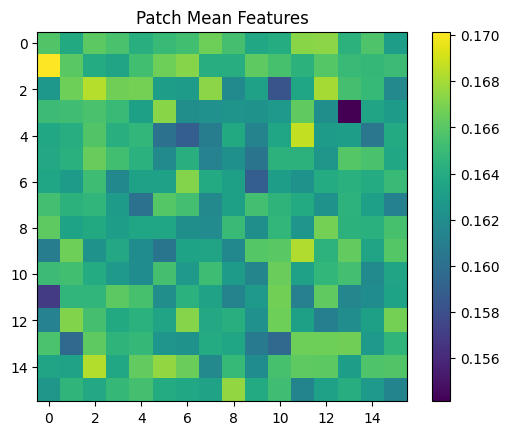

torch.Size([1, 16, 16, 1024])


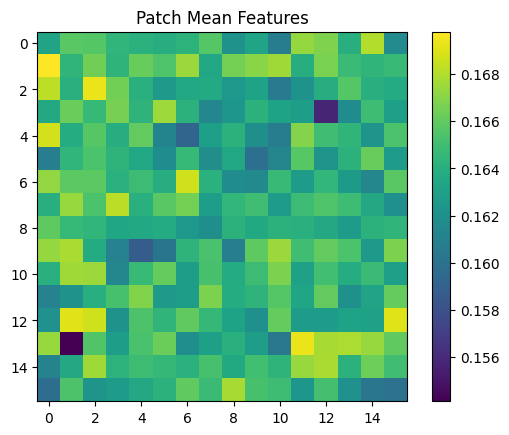

torch.Size([1, 16, 16, 1024])


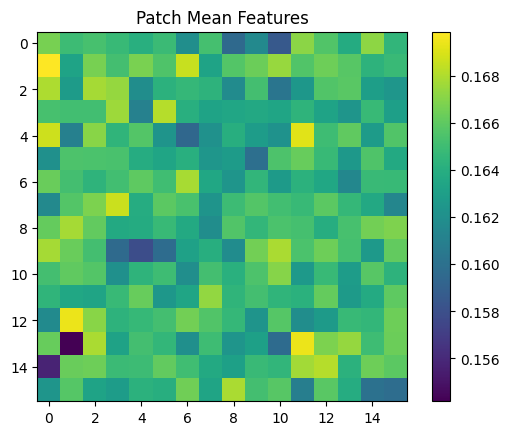

torch.Size([1, 16, 16, 1024])


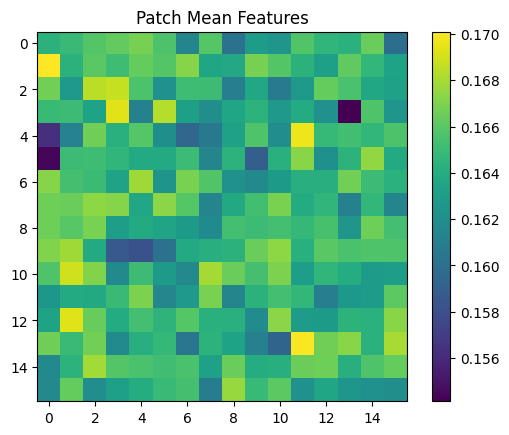

torch.Size([1, 16, 16, 1024])


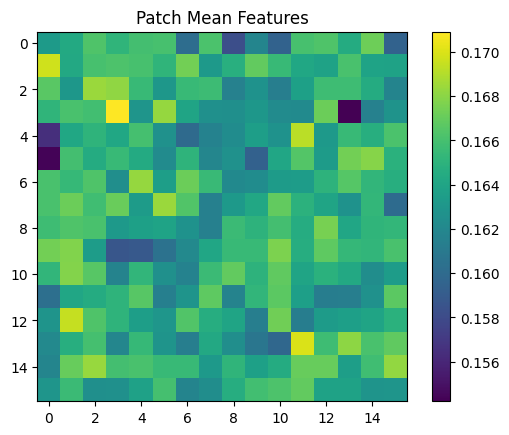

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

root_dir = Path(root_dir)
imagery_root = root_dir / "imagery"

model = load_backbone(backbone_type).to(device).eval()
print('debug')

df = pd.read_csv(f'{root_dir}/labels.csv', dtype=str)
if "article_id" not in df.columns:
    raise SystemExit("CSV missing required column: article_id")

article_ids = df["article_id"].tolist()
print(f"{len(article_ids)} articles found!")

i = 0
for article_id in article_ids:
    if i < 1:
        article_dir = imagery_root / str(article_id)

        if not article_dir.is_dir():
            print(f"[skip] {article_id} (missing: {article_dir})")
            continue

        jpg_paths = sorted(article_dir.rglob("*.jpg"), key=lambda p: str(p).lower())
        if not jpg_paths:
            print(f"[skip] {article_id} (no .jpg under {article_dir})")
            continue

        print(f"\n=== {article_id} ({len(jpg_paths)} images) ===")
        eval_cpd(jpg_paths, model, backbone_type=backbone_type, device=device)
    i+=1